# 

In [11]:
# import torchvision.transforms as T
# import torchvision.datasets as ds
# from torch.utils.data import DataLoader, random_split
# import os
# import pathlib
# import torch, torch.nn as nn, torch.optim as optim
# import timm
# from torchmetrics.classification import MulticlassAccuracy
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"
# torch.cuda.set_device(4)

# BATCH      = 128           
# IMG_SIZE   = 224             
# WORKERS    = os.cpu_count() 
# print('Number of CPU', WORKERS)

# train_tfms = T.Compose([
#     T.Resize(IMG_SIZE),
#     T.RandomHorizontalFlip(),
#     T.ToTensor(),
#     T.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
# ])

# test_tfms  = T.Compose([
#     T.Resize(IMG_SIZE),
#     T.ToTensor(),
#     T.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
# ])

# root = pathlib.Path.home() / "data-cifar10"
# full_train = ds.CIFAR10(root, train=True,  download=True, transform=train_tfms)
# test_set   = ds.CIFAR10(root, train=False, download=True, transform=test_tfms)

# train_set, val_set = random_split(full_train, [45_000, 5_000],
#                                   generator=torch.Generator().manual_seed(42))

# train_loader = DataLoader(train_set, BATCH, shuffle=True,  num_workers=WORKERS)
# val_loader   = DataLoader(val_set,   BATCH, shuffle=False, num_workers=WORKERS)
# test_loader  = DataLoader(test_set,  BATCH, shuffle=False, num_workers=WORKERS)


# DEVICE = "cuda" 
# NUM_EPOCHS  = 300            
# LR          = 3e-4
# MODEL_NAME  = "deit_tiny_patch16_224"

# model = timm.create_model(MODEL_NAME,
#                           pretrained=False,      
#                           num_classes=10)
# model.to(DEVICE)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# def run_epoch(loader, train: bool):
#     model.train(train)
#     acc = MulticlassAccuracy(num_classes=10).to(DEVICE)
#     loss_sum = 0
#     for images, labels in loader:
#         images, labels = images.to(DEVICE), labels.to(DEVICE)

#         if train:
#             optimizer.zero_grad()

#         with torch.set_grad_enabled(train):
#             logits = model(images)
#             loss   = criterion(logits, labels)
#             if train:
#                 loss.backward()
#                 optimizer.step()

#         loss_sum += loss.item() * images.size(0)
#         acc.update(logits.softmax(1), labels)

#     return loss_sum / len(loader.dataset), acc.compute().item()

# history = {"tr_loss":[], "tr_acc":[], "val_loss":[], "val_acc":[]}

# for epoch in range(1, NUM_EPOCHS+1):
#     tr_loss, tr_acc = run_epoch(train_loader, train=True)
#     vl_loss, vl_acc = run_epoch(val_loader,   train=False)

#     history["tr_loss"].append(tr_loss)
#     history["tr_acc"].append(tr_acc)
#     history["val_loss"].append(vl_loss)
#     history["val_acc"].append(vl_acc)

#     print(f"[{epoch:02d}/{NUM_EPOCHS}] "
#           f"train acc {tr_acc:.3%} | val acc {vl_acc:.3%}")

# torch.save(model.state_dict(), "deit_tiny_cifar10_scratch_2.pth")




Number of CPU 48


100%|██████████| 170M/170M [00:02<00:00, 75.0MB/s] 


Extracting /home/daoqm/data-cifar10/cifar-10-python.tar.gz to /home/daoqm/data-cifar10
Files already downloaded and verified
[01/300] train acc 32.011% | val acc 36.571%
[02/300] train acc 43.188% | val acc 46.560%
[03/300] train acc 49.383% | val acc 50.976%
[04/300] train acc 53.232% | val acc 54.546%
[05/300] train acc 56.962% | val acc 55.934%
[06/300] train acc 59.821% | val acc 56.848%
[07/300] train acc 61.496% | val acc 59.769%
[08/300] train acc 63.760% | val acc 61.370%
[09/300] train acc 65.190% | val acc 61.143%
[10/300] train acc 66.365% | val acc 65.310%
[11/300] train acc 68.148% | val acc 64.653%
[12/300] train acc 69.574% | val acc 66.719%
[13/300] train acc 71.046% | val acc 67.757%
[14/300] train acc 72.109% | val acc 68.529%
[15/300] train acc 73.608% | val acc 67.686%
[16/300] train acc 74.655% | val acc 69.532%
[17/300] train acc 75.524% | val acc 71.528%
[18/300] train acc 76.744% | val acc 71.327%
[19/300] train acc 77.903% | val acc 71.090%
[20/300] train acc 7

In [2]:
import pathlib
import torch
import torchvision.datasets as ds
import torchvision.transforms as T
from torch.utils.data import DataLoader
import timm

# --- 0. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 224
batch_size = 128
root = pathlib.Path.home() / "data-cifar10"

# transforms + loader
test_tfms = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
])
test_set    = ds.CIFAR10(root, train=False, download=True, transform=test_tfms)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# evaluation helper
def evaluate(model, loader):
    model.eval()
    top1_correct = 0
    top5_correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)

            # Top-1
            _, p1 = logits.topk(1, dim=1)
            top1_correct += (p1.squeeze(1) == labels).sum().item()

            # Top-5
            _, p5 = logits.topk(5, dim=1)
            top5_correct += sum(int(labels[i] in p5[i]) for i in range(labels.size(0)))
            total += labels.size(0)

    return 100 * top1_correct/total, 100 * top5_correct/total

# --- 1. Tiny DeiT (scratch) ---
# a) rebuild arch
model_tiny = timm.create_model("deit_tiny_patch16_224", pretrained=False, num_classes=10)
# b) load your raw state_dict
state_dict = torch.load("deit_tiny_cifar10_scratch_2.pth", map_location=device)
model_tiny.load_state_dict(state_dict)
model_tiny.to(device)

# c) eval
t1, t5 = evaluate(model_tiny, test_loader)
print(f"[Tiny‑scratch]  Top‑1: {t1:.2f}%,  Top‑5: {t5:.2f}%")

# --- 2. Small DeiT Distilled (ImageNet pretrained) ---
model_small = timm.create_model("deit_base_distilled_patch16_224", pretrained=True, num_classes=10)
model_small.to(device)

t1s, t5s = evaluate(model_small, test_loader)
print(f"[Small‑distilled]  Top‑1: {t1s:.2f}%,  Top‑5: {t5s:.2f}%")


/opt/miniforge3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


/tmp/ipykernel_877762/1389627459.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("deit_tiny_cifar10_scratch_2.pth", map_location=device)


[Tiny‑scratch]  Top‑1: 78.07%,  Top‑5: 97.32%
[Small‑distilled]  Top‑1: 7.73%,  Top‑5: 43.98%


In [5]:
import torchvision.transforms as T
import torchvision.datasets as ds
from torch.utils.data import DataLoader, random_split
import os
import pathlib
import torch, torch.nn as nn, torch.optim as optim
import timm
from torchmetrics.classification import MulticlassAccuracy
BATCH      = 128           
IMG_SIZE   = 224             
WORKERS    = os.cpu_count() 
train_tfms = T.Compose([
    T.Resize(IMG_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
])

test_tfms  = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=(0.5,)*3, std=(0.5,)*3),
])
root = pathlib.Path.home() / "data-cifar10"
full_train = ds.CIFAR10(root, train=True,  download=True, transform=train_tfms)
test_set   = ds.CIFAR10(root, train=False, download=True, transform=test_tfms)

train_set, val_set = random_split(full_train, [45_000, 5_000],
                                  generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, BATCH, shuffle=True,  num_workers=WORKERS)
val_loader   = DataLoader(val_set,   BATCH, shuffle=False, num_workers=WORKERS)
test  = DataLoader(test_set,  BATCH, shuffle=False, num_workers=WORKERS)
model = timm.create_model("deit_small_distilled_patch16_224",
                          pretrained=True,
                          num_classes=10)
model.to(device)

# freeze everything except the head (optional)
# for name, p in model.named_parameters():
#     if "head" not in name:
#         p.requires_grad = False

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad,
                                    model.parameters()),
                              lr=1e-3)
criterion = nn.CrossEntropyLoss()

# simple fine‑tune loop
for epoch in range(5):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
    print("Epoch", epoch, "done")

# now eval…
t1, t5 = evaluate(model, test_loader)
print("After fine‑tuning →", t1, t5)


Files already downloaded and verified
Files already downloaded and verified
Epoch 0 done
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
After fine‑tuning → 77.4 98.91


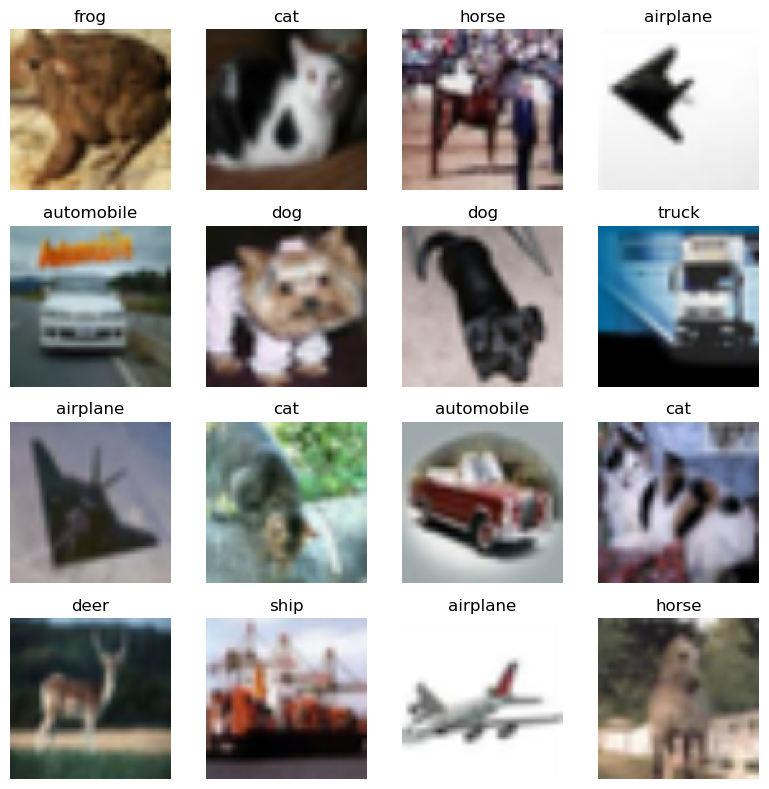

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 1) get the class names from the dataset
class_names = full_train.classes  
# ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# 2) grab one batch
imgs, labels = next(iter(train_loader))

# 3) undo the normalize(mean=0.5,std=0.5) → img*0.5 + 0.5 puts pixels back in [0,1]
imgs = imgs * 0.5 + 0.5  

# 4) plot a 4×4 grid of the first 16 images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flatten()):
    img = imgs[i].permute(1, 2, 0).cpu().numpy()
    ax.imshow(img, interpolation='nearest')
    ax.set_title(class_names[labels[i].item()])
    ax.axis('off')

plt.tight_layout()
plt.show()
